In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import torch.nn.functional as F
from torch import optim
import pandas as pd
import matplotlib.pyplot as plt
import anndata
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ensure root directory of the project
import os
if not os.getcwd().endswith('perturbations'):
    os.chdir('/home/fvk220/fvk220/sc-perturbations')

# load custom classes and functions
from _models import NBVAE
import _utils
from _utils import set_all_seeds, truncate_colormap, set_plt_layout, take_cmap_colors
from _utils import load_model, save_model, evaluate_dataset
from _training import train_nbvae_embryotime
set_all_seeds(0)
set_plt_layout()


class RNA(Dataset):
    def __init__(self, data_file, subset=None):
        # load the scRNA-seq data from the specified file
        self.data = anndata.read_h5ad(data_file)
        self.data = self.data[subset] if subset is not None else self.data
        self.genes = self.data.var_names.values
        self.cells = self.data.obs_names.values
        self.obs = self.data.obs
        self.time_raw = torch.tensor(self.obs["time_raw"].astype(float), dtype=torch.float32)
        self.time_raw_unmasked = self.time_raw.clone()
        self.data = torch.from_numpy(
             self.data.X.toarray())
        print(self.data.shape)

        # scale cell counts by their mean
        self.data_mean = torch.mean(self.data, dim=-1, keepdim=True)
        self.normalized_data = self.data / self.data_mean
        self.log_data = torch.log1p(self.normalized_data)

        print("Before norm:", torch.min(self.data), torch.max(self.data))
        print("After norm:", torch.min(self.normalized_data), torch.max(self.normalized_data))
        print("Log data:", torch.min(self.log_data), torch.max(self.log_data))

    def __len__(self):
        # return the number of examples in the dataset
        return len(self.data)

    def __getitem__(self, index):
        # return the preprocessed data for the specified example
        return index, self.data[index], self.data_mean[index], self.normalized_data[index], self.log_data[index], self.time_raw[index]

dev = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
bs = 2**12
train_pct = 0.82; val_pct = 0.09; test_pct = 0.09

# Load the dataset only once
full_dataset = RNA("data/celegans/anndata_hvg.h5ad")

# Split into train, validation, and test subsets
indices = np.arange(len(full_dataset))
np.random.shuffle(indices)

train_end = int(len(full_dataset) * train_pct)
val_end = train_end + int(len(full_dataset) * val_pct)

train_indices = indices[:train_end]
val_indices = indices[train_end:val_end]
test_indices = indices[val_end:]

# Define a function to generate subset data loader
def get_subset_loader(indices):
    subset = torch.utils.data.Subset(full_dataset, indices)
    return DataLoader(subset, batch_size=bs, shuffle=True)

train_loader = get_subset_loader(train_indices)
val_loader = get_subset_loader(val_indices)
test_loader = get_subset_loader(test_indices)

# SAMPLING RANDOM CELLS TO BE UNLABELLED
remove_targets = 0.9
sampled_indices = np.random.choice(train_indices, int(remove_targets * len(train_indices)), replace=False)
for idx in sampled_indices:
    full_dataset.time_raw[idx] = -1

# ALTERNATIVELY: PICKING JUST HYPODERMIS CELLS TO BE LABELLED
# mask = (full_dataset.obs["cell_type"] == "Hypodermis")
# full_dataset.time_raw[~mask] = -1
label_proportion = torch.sum(full_dataset.time_raw[train_indices] != -1) / len(full_dataset.time_raw[train_indices])

print("Proportion of labelled cells:", label_proportion)
print("Sizes:", len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

torch.Size([85951, 1832])
Before norm: tensor(0.) tensor(4283.)
After norm: tensor(0.) tensor(1598.8823)
Log data: tensor(0.) tensor(7.3777)
Proportion of labelled cells: tensor(0.1000)
Sizes: 70479 7735 7737


In [3]:
# TRAIN SINGLE MODEL
model_params = {"input_dim": len(full_dataset.data[0]), "latent_dim": 2, "scaling_type": "mean", "extra_outputs": 1}
vae = NBVAE(**model_params).to(dev)
vae_opt = optim.Adam(vae.parameters(), lr=1.2e-3, weight_decay=1e-5, amsgrad=True)
vae, vae_loss_hist = train_nbvae_embryotime(vae, vae_opt, train_loader, val_loader, 700, beta=10, warmup_epochs=10, patience=10, dev=dev, task_weight=1/label_proportion)

Epochs:   8%| | 59/700 [02:16<24:39,  2.31s/it, Loss=424.8331, Recon=370.9325, KL=4.3351, L1=1.0550, Val=748.2312, Be

Early stopping
Best epoch: 49 val loss: 729.7742081447964


In [4]:
# save_model(vae, vae_opt, vae_loss_hist, model_params, 'embryo')

# p = "checkpoints/embryo_20250222_160101.pt"
# vae, _, _, model_params = load_model(p, model_type='nbvae', dev=dev)

gene indices: [-1]


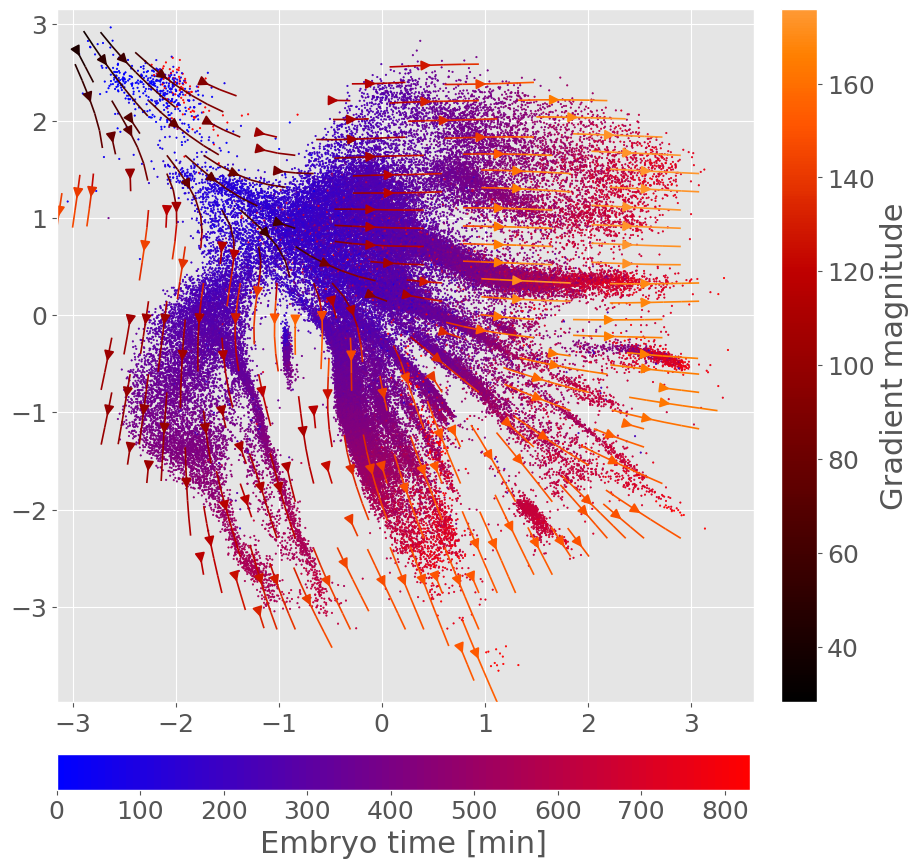

In [5]:
from scipy.ndimage import binary_dilation
from matplotlib.colors import LinearSegmentedColormap

# use full dataset 
x_hat, mu, metrics = evaluate_dataset(full_dataset.data, full_dataset.log_data, full_dataset.data_mean, vae,
                                      "embryotime", compute_ari=True, labels=full_dataset.time_raw_unmasked, 
                                      mask=full_dataset.time_raw!=-1, obs=full_dataset.obs)
metrics = pd.DataFrame([metrics])

boundaries = 1.15 * np.quantile(mu, [0.0001, 0.9999], axis=0)
x_min, y_min = boundaries[0] 
x_max, y_max = boundaries[1]
rectangle = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max], [x_min, y_min]])

# create a grid in the boundary region
grid_size = 35
x_grid = np.linspace(x_min, x_max, grid_size)
y_grid = np.linspace(y_min, y_max, grid_size)
x1, x2 = np.meshgrid(x_grid, y_grid)
flat = np.vstack([x1.flatten(), x2.flatten()]).T

gene_idx = [-1]
print("gene indices:", gene_idx)

# compute gradients and unflatten
J = vae.grad_wrt_i(torch.tensor(flat).to(dev).float(), gene_idx).detach().cpu().numpy()
J = J.mean(axis=1)

xx = J[:,0].reshape(len(x_grid), len(x_grid))
yy = J[:,1].reshape(len(y_grid), len(y_grid))
magnitude = np.sqrt(xx**2 + yy**2)

# mask out the region outside points
hist, _, _ = np.histogram2d(mu[:, 0].numpy(), mu[:, 1].numpy(), bins=[x_grid, y_grid])
mask = hist.T > 0
mask_padded = np.pad(mask, ((0, 1), (0, 1)), mode='constant')
mask_dilated = binary_dilation(mask_padded, iterations=1)
xx = np.where(mask_dilated, xx, np.nan)
yy = np.where(mask_dilated, yy, np.nan)

#---- semantic labels ----
obs = full_dataset.obs.copy()
c = obs.time_raw.astype("float")

# plotting
fig, ax = plt.subplots(figsize=(9,9))

colors = [(0, 0, 1), (1, 0, 0)]
cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=100)

scat = ax.scatter(mu[:, 0], mu[:, 1], s=1, c=c, cmap=cmap, alpha=1)

stream = ax.streamplot(x1, x2, xx, yy, linewidth=1.2, color=magnitude, cmap=truncate_colormap("gist_heat", 0, 0.8),
                       density=(1.3, 1.3), minlength=0.007, maxlength=0.3, arrowstyle='-|>', arrowsize=1.5)

colorbar_ax = fig.add_axes([0.93, 0.11, 0.04, 0.77])    # gradient cbar
cbar = fig.colorbar(stream.lines, cax=colorbar_ax, orientation="vertical")
cbar.set_label('Gradient magnitude')
colorbar2_ax = fig.add_axes([0.125, 0.013, 0.77, 0.04]) # embryotime cbar
cbar2 = fig.colorbar(scat, cax=colorbar2_ax, orientation="horizontal")
cbar2.set_label('Embryo time [min]')
cbar2.set_alpha(1)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
# plt.savefig(f"data/embryotime_preds_hidpi_5th_iter_final_newest.png", dpi=300, bbox_inches='tight')
plt.show()


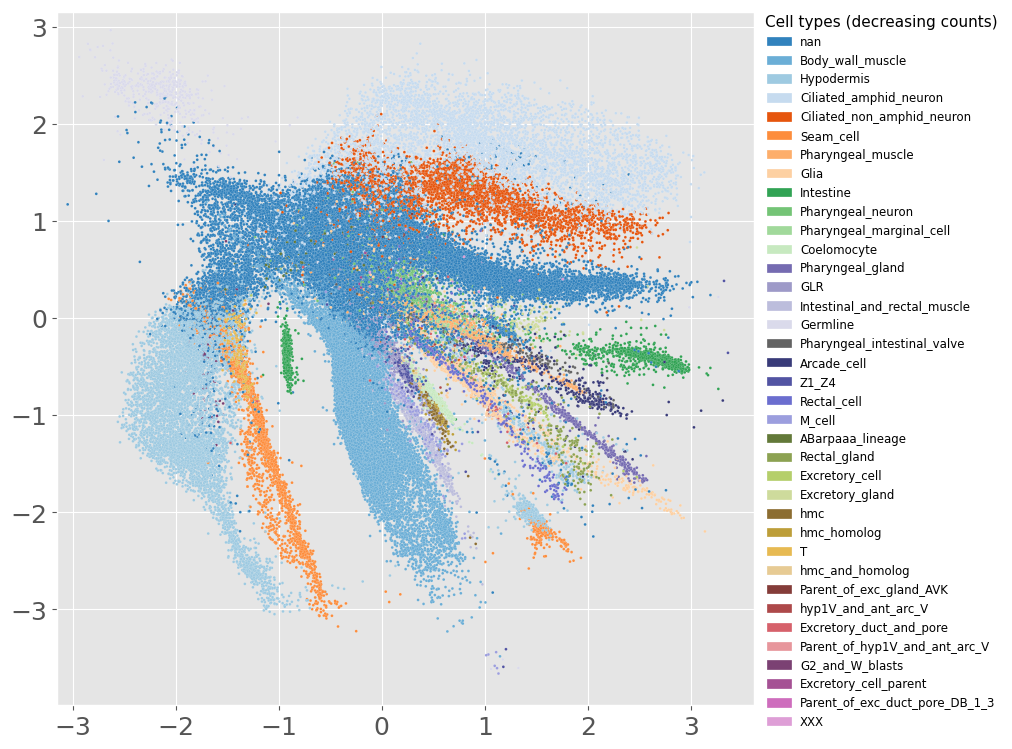

In [6]:
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors

obs = full_dataset.obs.copy()

cell_counts = obs['cell_type'].value_counts()
ordered_cell_types = cell_counts.index.tolist()
obs['cell_type'] = pd.Categorical(obs['cell_type'], categories=ordered_cell_types, ordered=True)
cmap = mcolors.ListedColormap(np.vstack([cm.tab20c.colors[:-3], cm.tab20b.colors]))

plt.figure(figsize=(9,9))
scat = plt.scatter(mu[:, 0], mu[:, 1], s=4, c=obs['cell_type'].cat.codes, cmap=cmap, alpha=1, edgecolors='w', linewidths=0.07)
handles = [mpatches.Patch(color=cmap(i), label=f"{cell_type}") 
           for i, cell_type in enumerate(ordered_cell_types)]
plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.482), ncol=1, title="Cell types (decreasing counts)", title_fontsize=11, fontsize=8.5, frameon=False)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
# plt.savefig(f"data/embryotime_cell_types_final_newest.png", dpi=300, bbox_inches='tight')
plt.show()


In [7]:
from _utils import evaluate_dataset

# TRAIN N_ITER MODELS
compute_ari = True
n_iter = 5
model_params = {"input_dim": len(full_dataset.data[0]), "latent_dim": 2, "scaling_type": "mean", "extra_outputs": 1}

train_results = []
test_results = []
for i in range(n_iter):
    # init model and train
    vae = NBVAE(**model_params).to(dev)
    vae_opt = optim.Adam(vae.parameters(), lr=1.2e-3, weight_decay=1e-5, amsgrad=True)
    vae, vae_loss_hist = train_nbvae_embryotime(vae, vae_opt, train_loader, val_loader, 1000, beta=10, warmup_epochs=10, patience=10, dev=dev, task_weight=1/label_proportion)
    vae.eval()

    print("TRAIN METRICS--------")
    _, _, train_metrics = evaluate_dataset(full_dataset.data[train_indices], full_dataset.log_data[train_indices], 
                                           full_dataset.data_mean[train_indices], vae, "embryotime", compute_ari, 
                                           labels=full_dataset.time_raw_unmasked[train_indices], 
                                           mask=full_dataset.time_raw[train_indices]!=-1, obs=full_dataset.obs.iloc[train_indices])
    print("\nTEST METRICS-------")
    _, _, test_metrics  = evaluate_dataset(full_dataset.data[test_indices], full_dataset.log_data[test_indices],
                                           full_dataset.data_mean[test_indices], vae, "embryotime", compute_ari,
                                           labels=full_dataset.time_raw_unmasked[test_indices], 
                                           mask=full_dataset.time_raw[test_indices]!=-1, obs=full_dataset.obs.iloc[test_indices])

    # save model
    # save_model(vae, vae_opt, vae_loss_hist, path=f"embryotime_nbvae_10pct_2D_{test_metrics['rmse']:.3f}")

    # append to lists with extra n_iter column
    train_results.append({'n_iter': i, **train_metrics})
    test_results.append({'n_iter': i, **test_metrics})

# convert to dataframe
train_df = pd.DataFrame(train_results)
test_df = pd.DataFrame(test_results)

# write dataframes with tamestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
train_df.to_csv(f"data/embryotime_train_{timestamp}.csv")
test_df.to_csv(f"data/embryotime_test_{timestamp}.csv")

# Calculate mean and standard deviation for train metrics
train_mean = train_df.drop(columns=["n_iter"]).mean()
train_std = train_df.drop(columns=["n_iter"]).std()
test_mean = test_df.drop(columns=["n_iter"]).mean()
test_std = test_df.drop(columns=["n_iter"]).std()

# Print the results
print("\nTRAIN STATISTICS--------")
for metric in train_mean.index:
    print(f"Mean {metric:>8}: ${train_mean[metric]:.3f} \pm {train_std[metric]:.3f}$")

print("\nTEST STATISTICS--------")
for metric in test_mean.index:
    print(f"Mean {metric:>8}: ${test_mean[metric]:.3f} \pm {test_std[metric]:.3f}$")


Epochs:   5%| | 50/1000 [01:53<36:03,  2.28s/it, Loss=429.4971, Recon=374.5409, KL=4.3897, L1=1.1059, Val=735.4269, B

Early stopping
Best epoch: 40 val loss: 727.8327731092437
TRAIN METRICS--------


best k: 5 ari: 0.33048426656762797
ari: 0.3305
rmse: 0.3087 mae: 0.2556 Subset L1: 11.5047 All L1: 27.8991

TEST METRICS-------
best k: 5 ari: 0.32158850764005364
ari: 0.3216
rmse: 0.3111 mae: 0.2565 Subset L1: 30.0876 All L1: 30.0876


Epochs:   4%| | 40/1000 [01:34<37:50,  2.37s/it, Loss=441.0760, Recon=382.9232, KL=4.3672, L1=1.4481, Val=793.0146, B

Early stopping
Best epoch: 30 val loss: 782.7922430510666
TRAIN METRICS--------


best k: 6 ari: 0.40264445778333524
ari: 0.4026
rmse: 0.3159 mae: 0.2577 Subset L1: 17.4027 All L1: 32.5651

TEST METRICS-------
best k: 6 ari: 0.3978654500748462
ari: 0.3979
rmse: 0.3175 mae: 0.2584 Subset L1: 34.3802 All L1: 34.3802


Epochs:   9%| | 90/1000 [03:26<34:51,  2.30s/it, Loss=408.5578, Recon=360.0408, KL=4.1121, L1=0.7396, Val=747.8274, B

Early stopping
Best epoch: 80 val loss: 736.5698448610214
TRAIN METRICS--------


best k: 4 ari: 0.3132316146289031
ari: 0.3132
rmse: 0.3022 mae: 0.2506 Subset L1: 6.9949 All L1: 31.0983

TEST METRICS-------
best k: 4 ari: 0.3086270762516005
ari: 0.3086
rmse: 0.3050 mae: 0.2517 Subset L1: 33.0848 All L1: 33.0848


Epochs:   7%| | 67/1000 [02:31<35:10,  2.26s/it, Loss=415.5638, Recon=363.6320, KL=4.2802, L1=0.9130, Val=742.8026, B

Early stopping
Best epoch: 57 val loss: 736.8234647705236
TRAIN METRICS--------


best k: 6 ari: 0.3028709390614779
ari: 0.3029
rmse: 0.3083 mae: 0.2558 Subset L1: 11.1251 All L1: 30.1728

TEST METRICS-------
best k: 7 ari: 0.32957744798653543
ari: 0.3296
rmse: 0.3105 mae: 0.2566 Subset L1: 31.9718 All L1: 31.9718


Epochs:   5%| | 53/1000 [01:53<33:51,  2.15s/it, Loss=429.0234, Recon=376.1847, KL=4.2386, L1=1.0453, Val=750.2318, B

Early stopping
Best epoch: 43 val loss: 736.5317388493859
TRAIN METRICS--------


best k: 4 ari: 0.3170435735414603
ari: 0.3170
rmse: 0.3069 mae: 0.2508 Subset L1: 9.8204 All L1: 28.2186

TEST METRICS-------
best k: 4 ari: 0.31218442960984827
ari: 0.3122
rmse: 0.3090 mae: 0.2516 Subset L1: 30.6815 All L1: 30.6815

TRAIN STATISTICS--------
Mean       l1: $11.370 \pm 3.808$
Mean   l1_all: $29.991 \pm 1.962$
Mean     rmse: $0.308 \pm 0.005$
Mean      mae: $0.254 \pm 0.003$
Mean      ari: $0.333 \pm 0.040$

TEST STATISTICS--------
Mean       l1: $32.041 \pm 1.749$
Mean   l1_all: $32.041 \pm 1.749$
Mean     rmse: $0.311 \pm 0.005$
Mean      mae: $0.255 \pm 0.003$
Mean      ari: $0.334 \pm 0.037$
